# Regression using Deep Neural Networks 

## Load Dataset from sklearn

In [ ]:
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 

from sklearn.preprocessing import StandardScaler 

import dataset 

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['TARGET'] = boston.target
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [4]:
scaler = StandardScaler()
scaler.fit(df.values[:,:-1]) # fitting mu, sigma 학습 
df.values[:,:-1] = scaler.transform(df.values[:,:-1]) # transforming 

df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,1.176466,0.387217,-0.418147,22.4
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,1.176466,0.441052,-0.500850,20.6
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,1.176466,0.441052,-0.983048,23.9
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,1.176466,0.403225,-0.865302,22.0
505,-0.415000,-0.487722,0.115738,-0.272599,0.158124,-0.362767,0.434732,-0.613246,-0.982843,-0.803212,1.176466,0.441052,-0.669058,11.9


## Train model with PyTorch

In [5]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [6]:
data = torch.from_numpy(df.values).float() # double float -> single float

data.shape 

torch.Size([506, 14])

In [7]:
y = data[:,-1:]
x = data[:,:-1]

print(x.shape, y.shape)

torch.Size([506, 13]) torch.Size([506, 1])


In [8]:
n_epochs = 100000
learning_rate = 1e-4
print_interval = 5000

 ## Build Models 

### Build Model using nn.Module

In [9]:
relu = nn.ReLU()
leaky_relu = nn.LeakyReLU(0.1)

In [10]:
class MyModel(nn.Module) : 
    
    def __init__(self, input_dim, output_dim) : 
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        super().__init__()
        
        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3, 3)
        self.linear3 = nn.Linear(3, output_dim)
        self.act = nn.ReLU()
        
    def forward(self, x) : 
        # |x| = (batch_size, input_dim) 506 x 13
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        y = self.linear3(h)
        # |y| = (batch_size, output_dim) 506 x 1 
        
        return y 
    
model = MyModel(x.size(-1), y.size(-1))

model

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)

### Build Model with LeakyReLU using nn.Sequential 

In [11]:
model = nn.Sequential(
    nn.Linear(x.size(-1),3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)

model

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=3, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=3, out_features=1, bias=True)
)

In [12]:
optimizer = optim.SGD(model.parameters(), # stochastic gradient descent w.r.t model parameters 
                      lr = learning_rate)  # declaring learning rate 

In [13]:
for i in range(n_epochs) : 
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y) 
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    if (i + 1) % print_interval == 0 : 
        print('Epoch %d : loss = %.4e' % (i + 1, loss))     

Epoch 5000 : loss = 1.4362e+01
Epoch 10000 : loss = 1.0287e+01
Epoch 15000 : loss = 9.6024e+00
Epoch 20000 : loss = 9.4387e+00
Epoch 25000 : loss = 9.2713e+00
Epoch 30000 : loss = 9.1239e+00
Epoch 35000 : loss = 9.0660e+00
Epoch 40000 : loss = 9.0543e+00
Epoch 45000 : loss = 8.8793e+00
Epoch 50000 : loss = 8.7520e+00
Epoch 55000 : loss = 8.6797e+00
Epoch 60000 : loss = 8.6690e+00
Epoch 65000 : loss = 8.6656e+00
Epoch 70000 : loss = 8.6628e+00
Epoch 75000 : loss = 8.6602e+00
Epoch 80000 : loss = 8.6588e+00
Epoch 85000 : loss = 8.6575e+00
Epoch 90000 : loss = 8.6562e+00
Epoch 95000 : loss = 8.6558e+00
Epoch 100000 : loss = 8.6549e+00


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


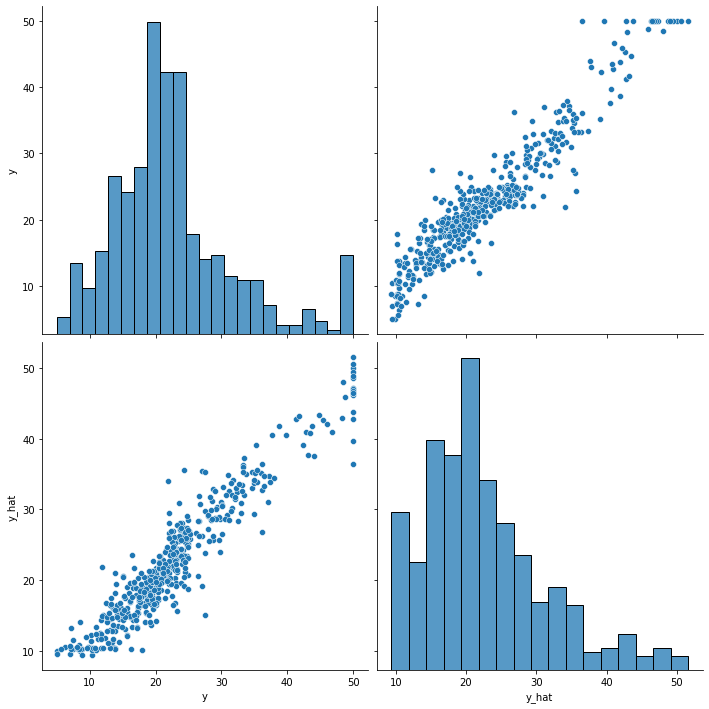

In [14]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach().numpy(),
                  columns = ['y', 'y_hat'])
sns.pairplot(df, size = 5) 
plt.show()